In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
!pip install -q tensorflow
!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install matplotlib-venn
!pip install pydub
import pydub
!pip show pydub
import matplotlib.pyplot as plt
print("tensorflow version:",tf.__version__)

Name: pydub
Version: 0.25.1
Summary: Manipulate audio with an simple and easy high level interface
Home-page: http://pydub.com
Author: James Robert
Author-email: jiaaro@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: 
tensorflow version: 2.18.0


In [2]:
ds_raw,ds_info = tfds.load('speech_commands',split='train[:2%]',with_info=True,as_supervised=True)
labels = ds_info.features['label'].names
print("sample labels:",labels[:10])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.4BOOEO_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.4BOOEO_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.4BOOEO_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.
sample labels: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(audio,label):
  audio=tf.cast(audio,tf.float32)/32768.0
  audio=tf.squeeze(audio)
  audio = tf.concat([audio,tf.zeros([16000]-tf.shape(audio),dtype=tf.float32)],0)[:16000]
  spectrogram = tf.signal.stft(audio,frame_length=255,frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram.set_shape([None,None])
  spectrogram = tf.expand_dims(spectrogram, -1)
  spectrogram = tf.image.resize(spectrogram, [124, 129])
  return spectrogram,tf.squeeze(tf.cast(label, tf.int32))




In [4]:
ds = ds_raw.map(preprocess).batch(32).cache().prefetch(AUTOTUNE)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(124, 129, 1)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax')])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
model.fit(ds, epochs=3)

Epoch 1/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.4759 - loss: 2.7786
Epoch 2/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 338ms/step - accuracy: 0.6500 - loss: 1.2576
Epoch 3/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.6928 - loss: 0.9588


In [7]:
from google.colab import files
!pip install tensorflow_io
import tensorflow as tf
uploaded = files.upload()
filename = list(uploaded.keys())[0]
audio_binary = tf.io.read_file(filename)
audio,sample_rate = tf.audio.decode_wav(audio_binary)
if tf.shape(audio)[1]==2:
  audio=tf.reduce_mean(audio,axis=1)
else:
  audio = tf.squeeze(audio,axis=-1)
desired_length = 16000
audio = audio[:desired_length]
audio=tf.pad(audio,[[0,tf.maximum(0,desired_length - tf.shape(audio)[0])]])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.3 MB/s eta 0:00:00


Saving WhatsApp Audio 2025-05-08 at 9.45.26 AM.wav to WhatsApp Audio 2025-05-08 at 9.45.26 AM.wav


In [8]:
spectrogram = tf.signal.stft(audio,frame_length=255,frame_step=128)
spectrogram = tf.abs(spectrogram)
spectrogram.set_shape([None,None])
spectrogram = tf.expand_dims(spectrogram,-1)
spectrogram = tf.image.resize(spectrogram,[124,129])
spectrogram = tf.expand_dims(spectrogram,0)

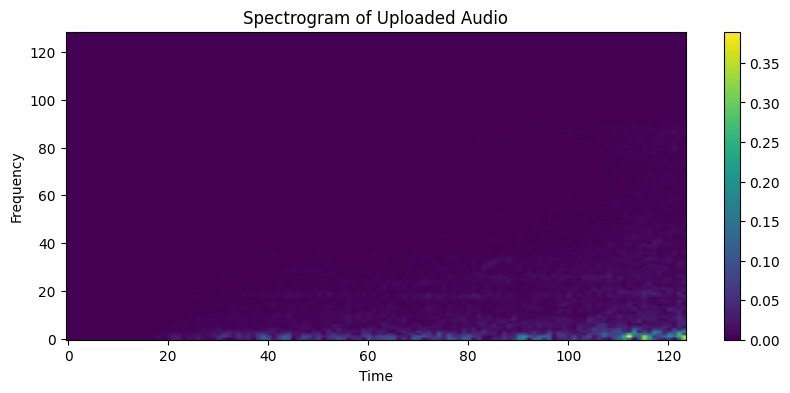

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.imshow(tf.squeeze(spectrogram).numpy().T,aspect='auto',origin='lower',cmap='viridis')
plt.title("Spectrogram of Uploaded Audio")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [10]:
prediction = model.predict(spectrogram)
predicted_class = labels[tf.argmax(prediction[0])]
print("predicted command:",predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
predicted command: _unknown_
